In [1]:
import tensorflow as tf

class TFNModel(tf.keras.Model):
    def __init__(self):
        super(TFNModel, self).__init__()

        # Згорткові шари
        self.conv1 = tf.keras.layers.Conv2D(32, (3, 3), activation='relu', padding='same')
        self.conv2 = tf.keras.layers.Conv2D(64, (3, 3), activation='relu', padding='same')

        # Пулінгові шари
        self.pooling = tf.keras.layers.MaxPooling2D(pool_size=(2, 2))

        # LSTM-рекурентний шар
        self.lstm = tf.keras.layers.LSTM(128, return_sequences=True)

        # Повнозв'язані шари
        self.flatten = tf.keras.layers.Flatten()
        self.dense1 = tf.keras.layers.Dense(64, activation='relu')

        # Вихідний шар
        self.output_layer = tf.keras.layers.Dense(1, activation='linear')

    def call(self, inputs):
        x = self.conv1(inputs)
        x = self.conv2(x)
        x = self.pooling(x)
        x = self.lstm(x)
        x = self.flatten(x)
        x = self.dense1(x)
        output = self.output_layer(x)
        return output

# Створення моделі
model = TFNModel()


In [2]:
# Import torch
import torch

# Exercises require PyTorch > 1.10.0
print(torch.__version__)

# Setup device agnostic code
device = "cuda" if torch.cuda.is_available() else "cpu"
device

2.0.1+cu118


'cpu'

In [3]:
# 1. Get data
import requests
import zipfile
from pathlib import Path

# Setup path to data folder
data_path = Path("data/")
image_path = data_path / "dataset"

# If the image folder doesn't exist, download it and prepare it...
if image_path.is_dir():
  print(f"{image_path} directory exists.")
else:
  print(f"Did not find {image_path} directory, creating...")
  image_path.mkdir(parents=True, exist_ok=True)

# Download dataset data (images from GitHub)
with open(data_path / "dataset.zip", "wb") as f:
  request = requests.get("https://github.com/dsmoliienko/tfn/raw/main/dataset2.zip")
  print("Downloading dataset data...")
  f.write(request.content)

# Unzip dataset data
with zipfile.ZipFile(data_path/"dataset.zip", "r") as zip_ref:
  print(f"Unzipping dataset data to {image_path}")
  zip_ref.extractall(image_path)

Did not find data/dataset directory, creating...
Unzipping dataset data to data/dataset


In [4]:
import os
def walk_through_dir(dir_path):
  """Walks through dir_path returning file counts of its contents."""
  for dirpath, dirnames, filenames in os.walk(dir_path):
    print(f"There are {len(dirnames)} directories and {len(filenames)} images in '{dirpath}'.")
walk_through_dir(image_path)

There are 2 directories and 0 images in 'data/dataset'.
There are 2 directories and 0 images in 'data/dataset/train'.
There are 0 directories and 14 images in 'data/dataset/train/clean'.
There are 0 directories and 14 images in 'data/dataset/train/dirty'.
There are 2 directories and 0 images in 'data/dataset/test'.
There are 0 directories and 14 images in 'data/dataset/test/clean'.
There are 0 directories and 14 images in 'data/dataset/test/dirty'.


In [5]:
# Setup train and testing paths
train_dir = image_path / "train"
test_dir = image_path / "test"

train_dir, test_dir

(PosixPath('data/dataset/train'), PosixPath('data/dataset/test'))

Random image path: data/dataset/test/clean/clean_95.jpg
Image class: clean
Image height: 375
Image width: 600


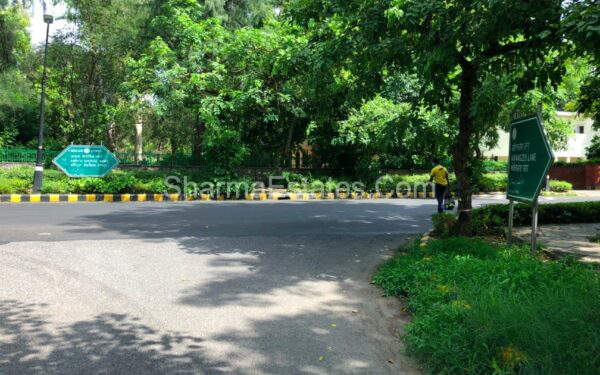

In [6]:
import random
from PIL import Image

# Set seed
random.seed(42) # <- try changing this and see what happens

# 1. Get all image paths (* means "any combination")
image_path_list = list(image_path.glob("*/*/*.jpg"))

# 2. Get random image path
random_image_path = random.choice(image_path_list)

# 3. Get image class from path name (the image class is the name of the directory where the image is stored)
image_class = random_image_path.parent.stem

# 4. Open image
img = Image.open(random_image_path)

# 5. Print metadata
print(f"Random image path: {random_image_path}")
print(f"Image class: {image_class}")
print(f"Image height: {img.height}")
print(f"Image width: {img.width}")
img

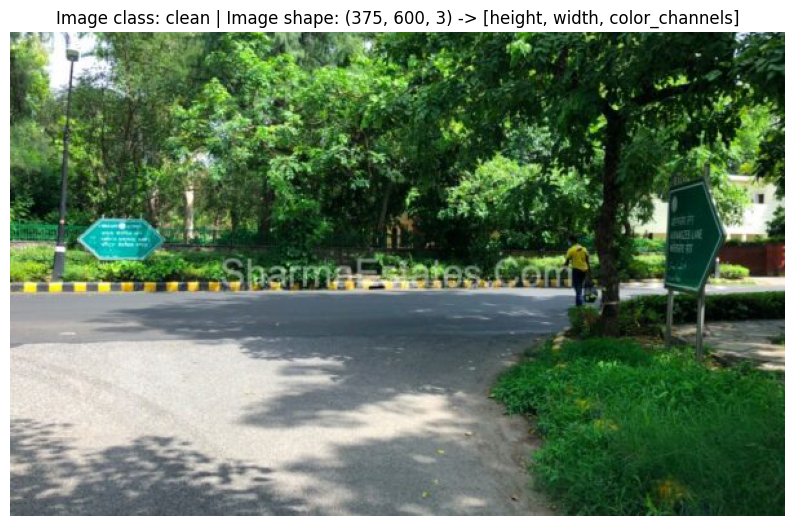

In [7]:
import numpy as np
import matplotlib.pyplot as plt

# Turn the image into an array
img_as_array = np.asarray(img)

# Plot the image with matplotlib
plt.figure(figsize=(10, 7))
plt.imshow(img_as_array)
plt.title(f"Image class: {image_class} | Image shape: {img_as_array.shape} -> [height, width, color_channels]")
plt.axis(False);

In [8]:
import torch
from torch.utils.data import DataLoader
from torchvision import datasets, transforms

In [9]:
# Write transform for image
data_transform = transforms.Compose([
    # Resize the images to 64x64
    transforms.Resize(size=(64, 64)),
    # Flip the images randomly on the horizontal
    transforms.RandomHorizontalFlip(p=0.5), # p = probability of flip, 0.5 = 50% chance
    # Turn the image into a torch.Tensor
    transforms.ToTensor() # this also converts all pixel values from 0 to 255 to be between 0.0 and 1.0
])

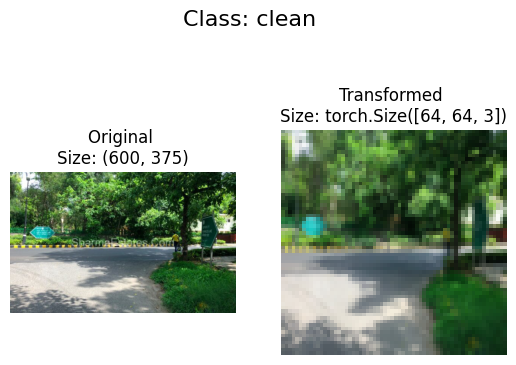

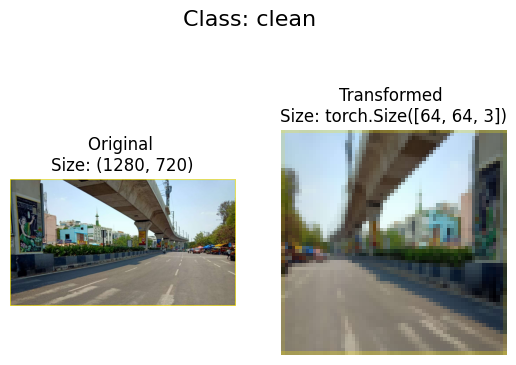

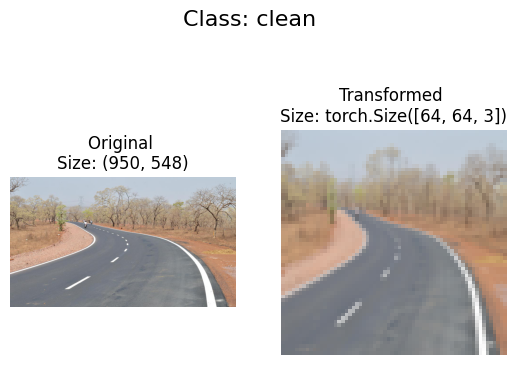

In [10]:
def plot_transformed_images(image_paths, transform, n=3, seed=42):
    """Plots a series of random images from image_paths.

    Will open n image paths from image_paths, transform them
    with transform and plot them side by side.

    Args:
        image_paths (list): List of target image paths.
        transform (PyTorch Transforms): Transforms to apply to images.
        n (int, optional): Number of images to plot. Defaults to 3.
        seed (int, optional): Random seed for the random generator. Defaults to 42.
    """
    random.seed(seed)
    random_image_paths = random.sample(image_paths, k=n)
    for image_path in random_image_paths:
        with Image.open(image_path) as f:
            fig, ax = plt.subplots(1, 2)
            ax[0].imshow(f)
            ax[0].set_title(f"Original \nSize: {f.size}")
            ax[0].axis("off")

            # Transform and plot image
            # Note: permute() will change shape of image to suit matplotlib
            # (PyTorch default is [C, H, W] but Matplotlib is [H, W, C])
            transformed_image = transform(f).permute(1, 2, 0)
            ax[1].imshow(transformed_image)
            ax[1].set_title(f"Transformed \nSize: {transformed_image.shape}")
            ax[1].axis("off")

            fig.suptitle(f"Class: {image_path.parent.stem}", fontsize=16)

plot_transformed_images(image_path_list,
                        transform=data_transform,
                        n=3)

In [11]:
# Use ImageFolder to create dataset(s)
from torchvision import datasets
train_data = datasets.ImageFolder(root=train_dir, # target folder of images
                                  transform=data_transform, # transforms to perform on data (images)
                                  target_transform=None) # transforms to perform on labels (if necessary)

test_data = datasets.ImageFolder(root=test_dir,
                                 transform=data_transform)

print(f"Train data:\n{train_data}\nTest data:\n{test_data}")

Train data:
Dataset ImageFolder
    Number of datapoints: 28
    Root location: data/dataset/train
    StandardTransform
Transform: Compose(
               Resize(size=(64, 64), interpolation=bilinear, max_size=None, antialias=warn)
               RandomHorizontalFlip(p=0.5)
               ToTensor()
           )
Test data:
Dataset ImageFolder
    Number of datapoints: 28
    Root location: data/dataset/test
    StandardTransform
Transform: Compose(
               Resize(size=(64, 64), interpolation=bilinear, max_size=None, antialias=warn)
               RandomHorizontalFlip(p=0.5)
               ToTensor()
           )


In [12]:
# Get class names as a list
class_names = train_data.classes
class_names

['clean', 'dirty']

In [13]:
# Can also get class names as a dict
class_dict = train_data.class_to_idx
class_dict

{'clean': 0, 'dirty': 1}

In [14]:
# Check the lengths
len(train_data), len(test_data)

(28, 28)

In [15]:
img, label = train_data[0][0], train_data[0][1]
print(f"Image tensor:\n{img}")
print(f"Image shape: {img.shape}")
print(f"Image datatype: {img.dtype}")
print(f"Image label: {label}")
print(f"Label datatype: {type(label)}")

Image tensor:
tensor([[[0.4431, 0.4392, 0.4392,  ..., 0.6392, 0.6275, 0.6196],
         [0.4392, 0.4392, 0.4353,  ..., 0.6039, 0.5804, 0.5765],
         [0.4471, 0.4431, 0.4392,  ..., 0.5804, 0.5686, 0.5804],
         ...,
         [0.1255, 0.1176, 0.1176,  ..., 0.0549, 0.1176, 0.1176],
         [0.1216, 0.1137, 0.1176,  ..., 0.0235, 0.0078, 0.0510],
         [0.1216, 0.1137, 0.1137,  ..., 0.0039, 0.0039, 0.0039]],

        [[0.4784, 0.4784, 0.4784,  ..., 0.6431, 0.6353, 0.6314],
         [0.4784, 0.4784, 0.4745,  ..., 0.6157, 0.6000, 0.5961],
         [0.4863, 0.4824, 0.4745,  ..., 0.5922, 0.5882, 0.6000],
         ...,
         [0.1176, 0.1098, 0.1098,  ..., 0.0471, 0.1176, 0.1137],
         [0.1137, 0.1059, 0.1098,  ..., 0.0196, 0.0039, 0.0471],
         [0.1137, 0.1059, 0.1059,  ..., 0.0000, 0.0000, 0.0000]],

        [[0.6039, 0.5882, 0.5804,  ..., 0.7020, 0.6941, 0.6902],
         [0.5882, 0.5843, 0.5765,  ..., 0.6745, 0.6549, 0.6510],
         [0.5882, 0.5804, 0.5725,  ..., 0.64

Original shape: torch.Size([3, 64, 64]) -> [color_channels, height, width]
Image permute shape: torch.Size([64, 64, 3]) -> [height, width, color_channels]


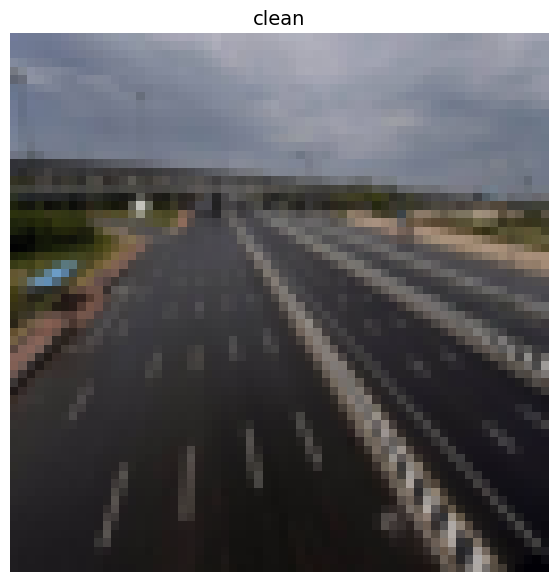

In [16]:
# Rearrange the order of dimensions
img_permute = img.permute(1, 2, 0)

# Print out different shapes (before and after permute)
print(f"Original shape: {img.shape} -> [color_channels, height, width]")
print(f"Image permute shape: {img_permute.shape} -> [height, width, color_channels]")

# Plot the image
plt.figure(figsize=(10, 7))
plt.imshow(img.permute(1, 2, 0))
plt.axis("off")
plt.title(class_names[label], fontsize=14);

In [17]:
from torch.utils.data import DataLoader
train_dataloader = DataLoader(dataset=train_data,
                              batch_size=1, # how many samples per batch?
                              num_workers=1, # how many subprocesses to use for data loading? (higher = more)
                              shuffle=True) # shuffle the data?

test_dataloader = DataLoader(dataset=test_data,
                             batch_size=1,
                             num_workers=1,
                             shuffle=False) # don't usually need to shuffle testing data

train_dataloader, test_dataloader

(<torch.utils.data.dataloader.DataLoader at 0x7fd0c14f5b10>,
 <torch.utils.data.dataloader.DataLoader at 0x7fd0c134ee60>)

In [18]:
img, label = next(iter(train_dataloader))

# Batch size will now be 1, try changing the batch_size parameter above and see what happens
print(f"Image shape: {img.shape} -> [batch_size, color_channels, height, width]")
print(f"Label shape: {label.shape}")

Image shape: torch.Size([1, 3, 64, 64]) -> [batch_size, color_channels, height, width]
Label shape: torch.Size([1])


In [23]:
import torch
import torchvision
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader


In [32]:
num_classes = 2

# Define the TFN model class
class TFNModel(nn.Module):
    def __init__(self):
        super(TFNModel, self).__init__()
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, stride=1, padding=1)
        self.relu1 = nn.ReLU()
        self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1)
        self.relu2 = nn.ReLU()
        self.pool2 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.flatten = nn.Flatten()
        self.fc1 = nn.Linear(64 * 16 * 16, 128)  # Adjust the input size based on your model's architecture
        self.relu3 = nn.ReLU()
        self.fc2 = nn.Linear(128, num_classes)  # Adjust the output size based on your task

    def forward(self, x):
        x = self.conv1(x)
        x = self.relu1(x)
        x = self.pool1(x)
        x = self.conv2(x)
        x = self.relu2(x)
        x = self.pool2(x)
        x = self.flatten(x)
        x = self.fc1(x)
        x = self.relu3(x)
        x = self.fc2(x)
        return x

In [33]:
# Instantiate the TFN model
model = TFNModel()


In [34]:
criterion = nn.CrossEntropyLoss()  # Use appropriate loss function
optimizer = optim.Adam(model.parameters(), lr=0.001)  # Use appropriate optimizer and learning rate

In [35]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)


TFNModel(
  (conv1): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (relu1): ReLU()
  (pool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (relu2): ReLU()
  (pool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (fc1): Linear(in_features=16384, out_features=128, bias=True)
  (relu3): ReLU()
  (fc2): Linear(in_features=128, out_features=2, bias=True)
)

In [36]:
num_epochs = 10
for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0

    for images, labels in train_dataloader:
        images, labels = images.to(device), labels.to(device)

        optimizer.zero_grad()

        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    train_loss = running_loss / len(train_dataloader)
    train_accuracy = 100 * correct / total

    print(f"Epoch [{epoch + 1}/{num_epochs}], Train Loss: {train_loss:.4f}, Train Accuracy: {train_accuracy:.2f}%")

# Evaluation on the test dataset
model.eval()
correct = 0
total = 0

with torch.no_grad():
    for images, labels in test_dataloader:
        images, labels = images.to(device), labels.to(device)

        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)

        total += labels.size(0)
        correct += (predicted == labels).sum().item()

test_accuracy = 100 * correct / total
print(f"Test Accuracy: {test_accuracy:.2f}%")


Epoch [1/10], Train Loss: 0.7230, Train Accuracy: 57.14%
Epoch [2/10], Train Loss: 0.6853, Train Accuracy: 50.00%
Epoch [3/10], Train Loss: 0.5983, Train Accuracy: 89.29%
Epoch [4/10], Train Loss: 0.4933, Train Accuracy: 75.00%
Epoch [5/10], Train Loss: 0.3943, Train Accuracy: 75.00%
Epoch [6/10], Train Loss: 0.3426, Train Accuracy: 89.29%
Epoch [7/10], Train Loss: 0.2969, Train Accuracy: 85.71%
Epoch [8/10], Train Loss: 0.2391, Train Accuracy: 89.29%
Epoch [9/10], Train Loss: 0.3127, Train Accuracy: 85.71%
Epoch [10/10], Train Loss: 0.1075, Train Accuracy: 96.43%
Test Accuracy: 78.57%


In [37]:
import urllib
from PIL import Image
import torchvision.transforms as transforms


In [38]:
def load_image_from_url(url):
    with urllib.request.urlopen(url) as f:
        image = Image.open(f).convert("RGB")
    return image

def preprocess_image(image):
    transform = transforms.Compose([
        transforms.Resize((64, 64)),
        transforms.ToTensor(),
    ])
    preprocessed_image = transform(image).unsqueeze(0)
    return preprocessed_image


In [45]:
image_url = "https://upload.wikimedia.org/wikipedia/commons/thumb/0/05/RoadEcologyConference2017-17.jpg/1200px-RoadEcologyConference2017-17.jpg"  # Replace with the URL of your random image
image = load_image_from_url(image_url)
preprocessed_image = preprocess_image(image)


In [46]:
preprocessed_image = preprocessed_image.to(device)


In [47]:
model.eval()
with torch.no_grad():
    outputs = model(preprocessed_image)
    _, predicted = torch.max(outputs.data, 1)

predicted_label = class_names[predicted.item()]  # Get the predicted label using the class_names list
print(f"Predicted label: {predicted_label}")

Predicted label: clean


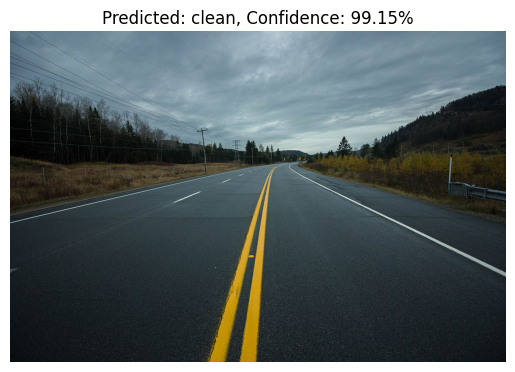

In [49]:
confidence_percentage = confidence_percentage.item()

# Plot the image
plt.imshow(image)
plt.axis("off")
plt.title(f"Predicted: {predicted_label}, Confidence: {confidence_percentage:.2f}%")
plt.show()


In [59]:
def predict_image(url):
    # Load and preprocess the image
    with urllib.request.urlopen(url) as f:
        image = Image.open(f).convert("RGB")

    transform = transforms.Compose([
        transforms.Resize((64, 64)),
        transforms.ToTensor(),
    ])

    preprocessed_image = transform(image).unsqueeze(0).to(device)

    # Make the prediction
    model.eval()
    with torch.no_grad():
        outputs = model(preprocessed_image)
        _, predicted = torch.max(outputs.data, 1)

    predicted_label = class_names[predicted.item()]
    confidence_percentage = torch.softmax(outputs, dim=1)[0][predicted].item() * 100

    # Plot the image with prediction results
    plt.imshow(image)
    plt.axis("off")
    plt.title(f"Predicted: {predicted_label}, Confidence: {confidence_percentage:.2f}%")
    plt.show()


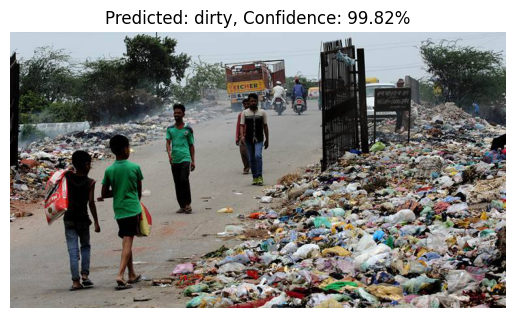

In [60]:
image_url = "https://images.indianexpress.com/2017/09/garbage-759.jpg"  # Replace with the URL of your new image
predict_image(image_url)